In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, pytz

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Hyperparameter

In [2]:
SEQ_LEN = 11 # 6, 11, 21
FOLD = 10 # 5, 10
LSTM_Layer = 1 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

In [3]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'EUR/IDR' # USD/IDR, EUR/IDR, SGD/IDR

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


## Preprocessing

In [4]:
def replace_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[data < lower_bound] = lower_bound
    data[data > upper_bound] = upper_bound
    return data

data['Close'] = replace_outliers(data['Close'])

/tmp/ipykernel_26/2274720815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < lower_bound] = lower_bound
/tmp/ipykernel_26/2274720815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data > upper_bound] = upper_bound


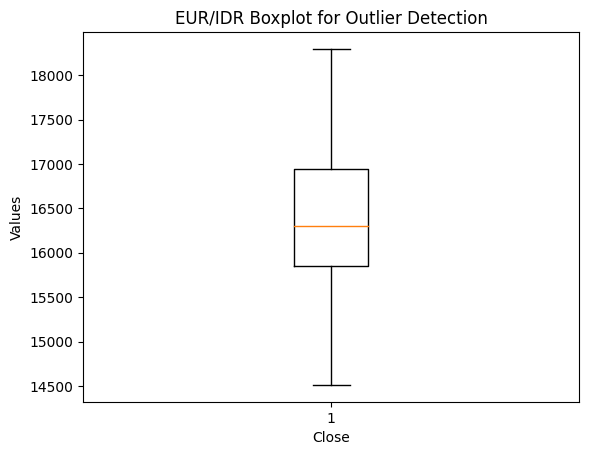

In [5]:
# Boxplot for outlier detection
plt.boxplot(data['Close'])
plt.title(f"{SHEET_NAME} Boxplot for Outlier Detection")
plt.xlabel("Close")
plt.ylabel("Values")
plt.show()

In [6]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

In [7]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len):
    data = to_sequences(data_raw, seq_len)
    target = data[:, -1, :]
    train = data[:, :-1, :]
    return train, target

inputs, targets = preprocess(scaled_close, SEQ_LEN)

tscv = TimeSeriesSplit(n_splits=FOLD)

## Genetic Algorithm

In [8]:
def decimal_to_binary(chromosome: list):
    binary_string = ''.join([bin(x)[2:].zfill(8) for x in chromosome])
    return binary_string

def binary_to_decimal(binary_string: str):
    decimal_array = [int(binary, 2) for binary in [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]]
    return decimal_array

In [9]:
# Genetic Algorithm
def genetic_algorithm(generations, mutation_rate):
    print(f"Inizialized Population...")
    population = np.random.randint(1, high=251, size=(10, 3))
    fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
    max_fitness_each_gen = []
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        max_fitness_each_gen.append(np.max(fitness_scores))
        
        chromosome_1 = selection(population, fitness_scores)
        chromosome_2 = selection(population, fitness_scores)
        
        if generation % mutation_rate == 0:
            chromosome_1 = mutate(chromosome_1)
            chromosome_2 = mutate(chromosome_2)
        else:
            chromosome_1, chromosome_2 = crossover(chromosome_1, chromosome_2)

        fitness_score_1 = fitness_function(chromosome_1)
        fitness_score_2 = fitness_function(chromosome_2)
        
        worst_index = np.argmin(fitness_scores)
        worst_fitness = fitness_scores[worst_index]

        if fitness_score_1 > worst_fitness:
            population[worst_index] = chromosome_1
            fitness_scores[worst_index] = fitness_score_1
            worst_index = np.argmin(fitness_scores)
            worst_fitness = fitness_scores[worst_index]

        if fitness_score_2 > worst_fitness:
            population[worst_index] = chromosome_2
            fitness_scores[worst_index] = fitness_score_2
        
        # Release some memory
        del chromosome_1, chromosome_2
        del fitness_score_1, fitness_score_2
        del worst_index, worst_fitness
            
    best_chromosome = population[np.argmax(fitness_scores)]
    best_fitness = np.max(fitness_scores)
    
    return best_chromosome, best_fitness, max_fitness_each_gen

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent_1: list, parent_2: list):
    parent_1 = decimal_to_binary(parent_1)
    parent_2 = decimal_to_binary(parent_2)
    
    crossover_point = np.random.randint(1, len(parent_1))
    offspring_1 = parent_1[:crossover_point] + parent_2[crossover_point:]
    offspring_2 = parent_2[:crossover_point] + parent_1[crossover_point:]
    
    offspring_1 = binary_to_decimal(offspring_1)
    offspring_2 = binary_to_decimal(offspring_2)
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome: list):
    chromosome = decimal_to_binary(chromosome)
    
    chromosome_list = list(chromosome)
    i = np.random.randint(len(chromosome_list), size=2)
    chromosome_list[i[0]], chromosome_list[i[1]] = chromosome_list[i[1]], chromosome_list[i[0]]
    
    chromosome_list = ''.join(chromosome_list)
    chromosome = binary_to_decimal(chromosome_list)
    return chromosome

# Define the fitness function to be optimized
def fitness_function(chromosome):
    loss = []
    lstm_units = [int(chromosome[i]) or default for i, default in enumerate([128, 64, 32])]

    print(f" Population")
    for fold_no, (train, test) in enumerate(tscv.split(inputs, targets)):
        print(f"  Fold - {fold_no}", end="")
        
        # Build the LSTM model
        tf.keras.backend.clear_session()
        model = Sequential()
        for i, units in enumerate(lstm_units[:LSTM_Layer]):
            model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
        model.add(Dense(1))

        # Compile and train the model
        model.compile(loss='mean_squared_error',
                      optimizer='adam')
        model.fit(inputs[train],
                  targets[train],
                  epochs=10,
                  batch_size=32,
                  verbose=0,
                  validation_split=0.1)

        # Evaluate the model
        loss.append(model.evaluate(inputs[test], targets[test], verbose=0))
    print()
    
    # Return the negative average value of the loss as the fitness score
    return -np.mean(loss)

In [10]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [11]:
# Do not increase this value
generations = 50
mutation_rate = 5

time = timer(None)
best_chromosome, best_fitness, max_fitness_each_gen = genetic_algorithm(generations, mutation_rate)
time = timer(time)

Inizialized Population...
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5  Fold - 6  Fold - 7  Fold - 8  Fold - 9
 Population
  Fold - 0  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold -

In [12]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [233  26 113]
Best Fitness: -0.001670805731555447
Time Taken: 1 hours 23 minutes and 49.8 seconds.


In [13]:
max_fitness_each_gen

[-0.001794550265185535,
 -0.001794550265185535,
 -0.001767948834458366,
 -0.001767948834458366,
 -0.001767948834458366,
 -0.00173480783123523,
 -0.00173480783123523,
 -0.00173480783123523,
 -0.00173480783123523,
 -0.00173480783123523,
 -0.00173480783123523,
 -0.0017167097772471606,
 -0.0017167097772471606,
 -0.0017167097772471606,
 -0.0017167097772471606,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017119249212555587,
 -0.0017099340446293354,
 -0.0017099340446293354,
 -0.0017099340446293354,
 -0.0017099340446293354,
 -0.0017099340446293354,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247781902,
 -0.0016846692247

## Re-Training Model with Best Parameter

In [14]:
metrics_per_fold = [[] for _ in range(3)]
metrics_inverse_per_fold = [[] for _ in range(3)]
y_test_per_fold, y_hat_inverse_per_fold = [], []
history_per_fold = []

for fold_no, (train, test) in enumerate(tscv.split(inputs, targets)):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    for i, units in enumerate(best_chromosome[:LSTM_Layer]):
        model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                  metrics=['mae', RootMeanSquaredError()],
                  optimizer='adam')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no+1} ...')
    
    history = model.fit(inputs[train],
                        targets[train],
                        epochs=50,
                        batch_size=32,
                        validation_split=0.1,
                        verbose=0)
    
    history_per_fold.append(history)
    
    # Model Evaluation
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    
    # Model Prediction
    y_hat = model.predict(inputs[test])
    y_test_inverse = scaler.inverse_transform(targets[test])
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    y_test_per_fold.append(y_test_inverse)
    y_hat_inverse_per_fold.append(y_hat_inverse)
    
    # Model Prediction Metrics
    mse_inverse = mean_squared_error(y_test_inverse, y_hat_inverse)
    mae_inverse = mean_absolute_error(y_test_inverse, y_hat_inverse)
    rmse_inverse = np.sqrt(mse_inverse)
       
    mse = mean_squared_error(targets[test], y_hat)
    mae = mean_absolute_error(targets[test], y_hat)
    rmse = np.sqrt(mse)

    print("Model Evaluate (model.evaluate) Result")
    print(f'Score for fold {fold_no+1}: {model.metrics_names[1]} is {scores[1]}; {model.metrics_names[0]}/mse is {scores[0]}; {model.metrics_names[2]} is {scores[2]}\n')
    
    print("Model Predict (model.predict) Result")
    print(f'Score for fold {fold_no+1}: mae is {mae}; mse is {mse}; rmse is {rmse}')
    print(f'Score for fold {fold_no+1}: mae is {mae_inverse}; mse is {mse_inverse}; rmse is {rmse_inverse}\n')

    metrics_inverse_per_fold[0].append(mae_inverse) # MAE Inverse
    metrics_inverse_per_fold[1].append(mse_inverse) # MSE Inverse
    metrics_inverse_per_fold[2].append(rmse_inverse) # RMSE Inverse
    
    metrics_per_fold[0].append(mae) # MAE
    metrics_per_fold[1].append(mse) # MSE
    metrics_per_fold[2].append(rmse) # RMSE

------------------------------------------------------------------------
Training for fold 1 ...
6/6 [==============================] - 1s 4ms/step
Model Evaluate (model.evaluate) Result
Score for fold 1: mae is 0.0331583246588707; loss/mse is 0.001758215599693358; root_mean_squared_error is 0.04193108156323433

Model Predict (model.predict) Result
Score for fold 1: mae is 0.03315832322912634; mse is 0.0017582155327163385; rmse is 0.041931080748250915
Score for fold 1: mae is 125.47115789150271; mse is 25175.305353358985; rmse is 158.66727877340995

------------------------------------------------------------------------
Training for fold 2 ...
6/6 [==============================] - 0s 2ms/step
Model Evaluate (model.evaluate) Result
Score for fold 2: mae is 0.029771754518151283; loss/mse is 0.002472961787134409; root_mean_squared_error is 0.0497288815677166

Model Predict (model.predict) Result
Score for fold 2: mae is 0.029771757046972335; mse is 0.0024729619078750925; rmse is 0.04972

## Model Evaluation

In [15]:
title = ['MAE', 'MSE', 'RMSE']
for i, unit in enumerate(metrics_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [0.03315832322912634, 0.029771757046972335, 0.016080899227712407, 0.0346769361537132, 0.017889147298971748, 0.018794937498720084, 0.030313657765337832, 0.016547945220905066, 0.026856128379129457, 0.02115668039745308]
Average Training Value : 0.024524641221804155

----------- MSE -----------
Value per Fold : [0.0017582155327163385, 0.0024729619078750925, 0.0004663910589339236, 0.0026349229083542907, 0.0005610548834755046, 0.0008378422720019917, 0.0020387522583060497, 0.0005407303907512126, 0.00140197386158915, 0.0007598737617156877]
Average Training Value : 0.001347271883571924

----------- RMSE -----------
Value per Fold : [0.041931080748250915, 0.04972888404011387, 0.02159608897309704, 0.05133150015686558, 0.023686597127394737, 0.028945505212415824, 0.045152544317081954, 0.02325361027348684, 0.03744294141208927, 0.02756580783716827]
Average Training Value : 0.03506345600979643



In [16]:
for i, unit in enumerate(metrics_inverse_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [125.47115789150271, 112.65630418363757, 60.85015712780897, 131.21756562148877, 67.69249892380624, 71.12011674859552, 114.7069276685393, 62.61742121664337, 101.62365958567399, 80.05694412745802]
Average Training Value : 92.80127530951543

----------- MSE -----------
Value per Fold : [25175.305353358985, 35409.47169839959, 6678.096894009198, 37728.57246783101, 8033.5463250013645, 11996.786688793201, 29192.185637175986, 7742.532055440961, 20074.398847645476, 10880.385713536429]
Average Training Value : 19291.12816811922

----------- RMSE -----------
Value per Fold : [158.66727877340995, 188.17404629331747, 81.71962367760389, 194.2384423018034, 89.63005257725426, 109.52984382711956, 170.85720832664916, 87.9916590106185, 141.68415171657512, 104.30908739671932]
Average Training Value : 132.68013939010706



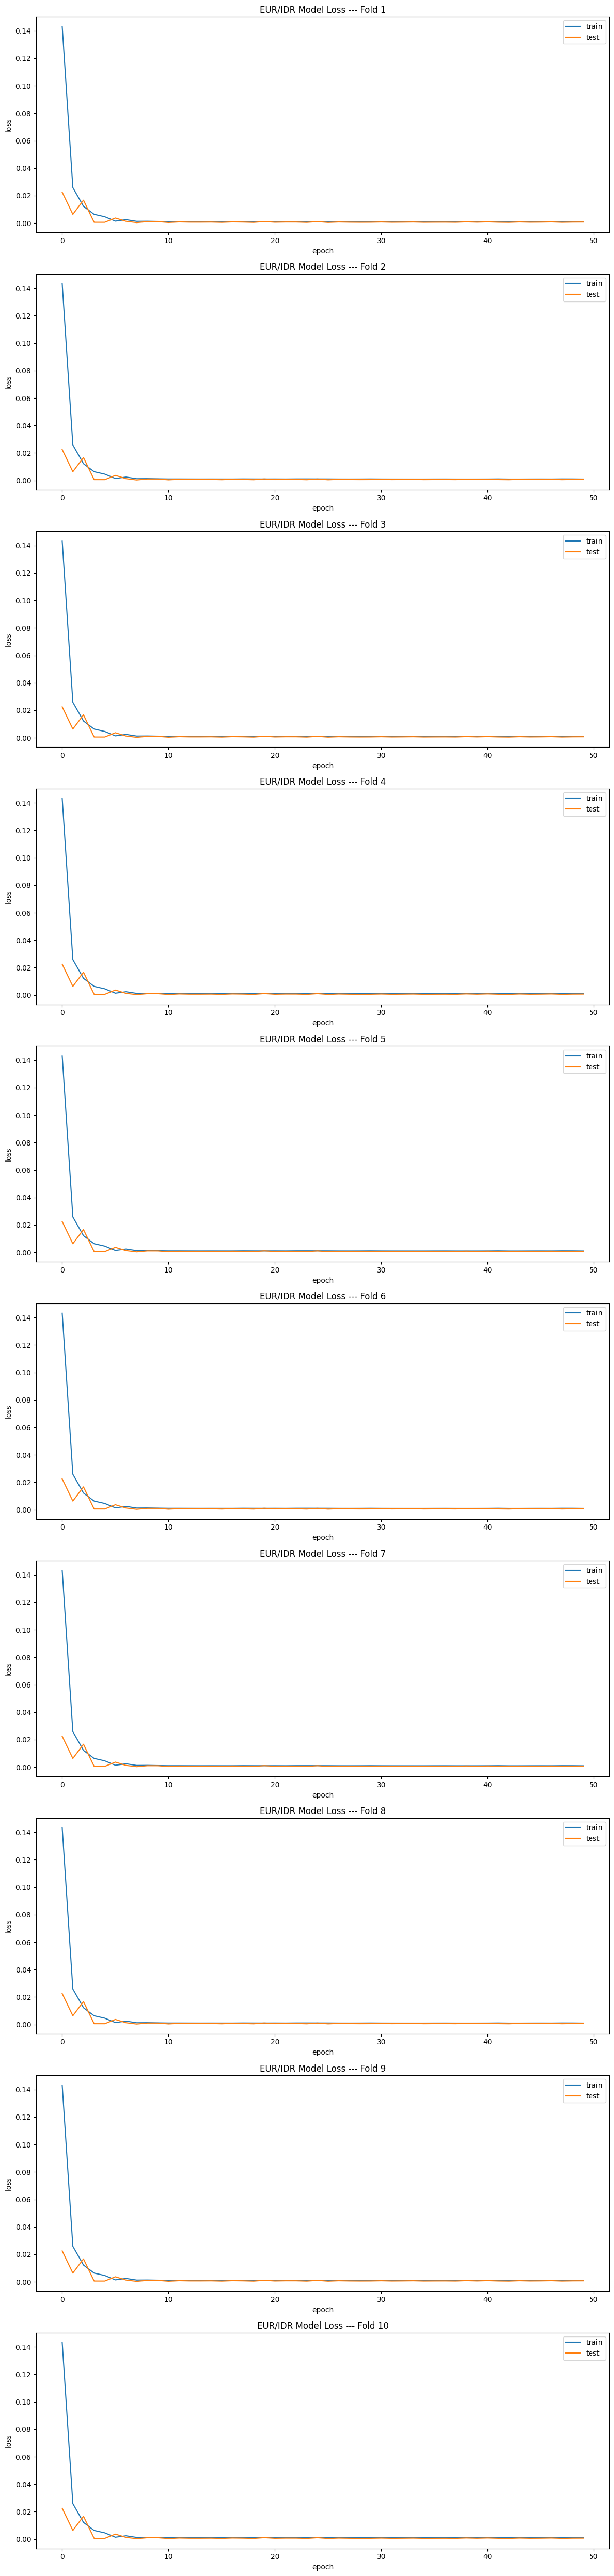

In [17]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(history_per_fold[0].history['loss'])
    axs[i].plot(history_per_fold[0].history['val_loss'])

    axs[i].set_title(f'{SHEET_NAME} Model Loss --- Fold {i+1}')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('loss')
    axs[i].legend(['train', 'test'], loc='best')

plt.tight_layout()
plt.show()

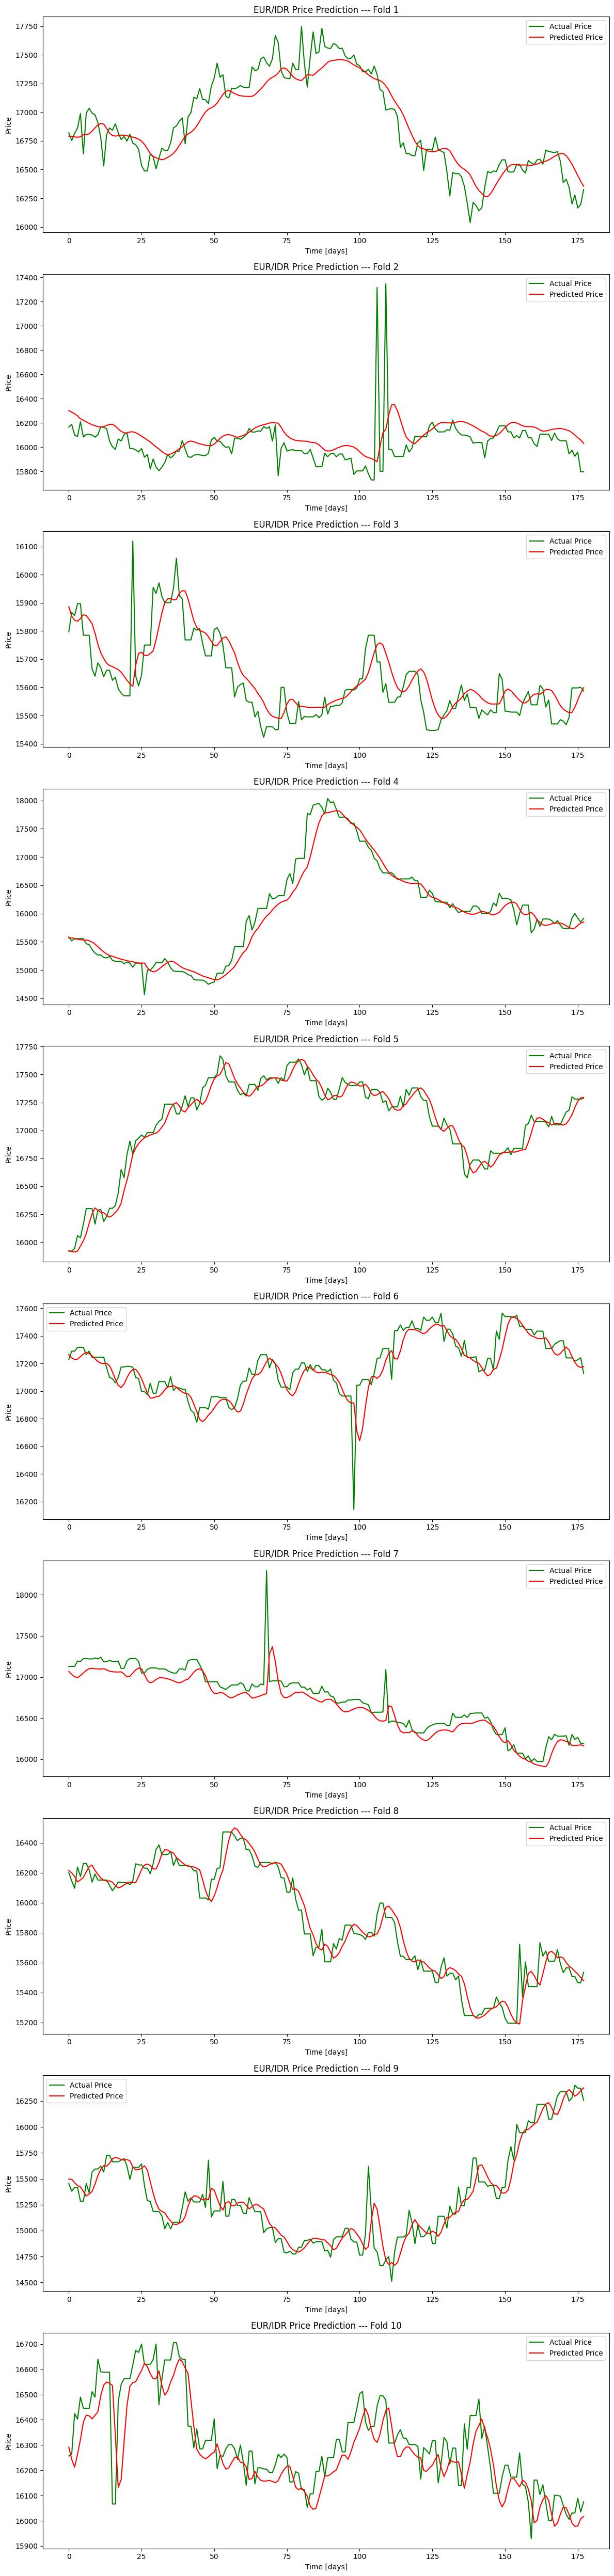

In [18]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(y_test_per_fold[i], label="Actual Price", color='green')
    axs[i].plot(y_hat_inverse_per_fold[i], label="Predicted Price", color='red')

    axs[i].set_title(f'{SHEET_NAME} Price Prediction --- Fold {i+1}')
    axs[i].set_xlabel('Time [days]')
    axs[i].set_ylabel('Price')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()